## Python notebook 
V nasledujúcom notebooku sú popísané Python metódy použité pre analýzu dát. Obsah notebooku je nasledujúci:
1. Import potrebných knižníc
2. Predspracovanie dát a inicializácia data augmetora
3. Hlboké učenie
4. Vyhodnotenie modelu
5. Vizuálne overenie nesprávne zaklasifikovaných udalostí

# 1. Import potrebných knižníc

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install opencv-python

In [ ]:
import numpy as np
import cv2 #obrázok na pole konverzia
import os
import random
import matplotlib.pyplot as plt
import pickle

import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show

import tensorflow
from tensorflow.image import random_contrast, random_brightness
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import albumentations as A
from sklearn.model_selection import train_test_split
from ImageDataAugmentor.image_data_augmentor import *

# 2. Predspracovanie dát a inicializácia data augmetora
Pri augmentáciách sa menia parametre obrázkov podľa nastaveného vzorca a pravdepodobnosti. Mení sa Gamma, Jas a Kontrast obrázkov. Na overenie správnej funkčnosti augmentora sme ho použili na testovacom obrázku.

In [2]:
#nastavenie augmentora
AUGMENTATIONS = albumentations.Compose([
    albumentations.RandomGamma((100, 200), p=.5),
    albumentations.RandomBrightnessContrast((-0.05, .15), (-.05, .1), p=.5)
])
SEED = 150

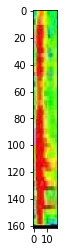

In [3]:
#vizualizacia jednej zachytenej udalosti
img = cv2.imread('ch1_20150902_231933_448_s61_2831.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

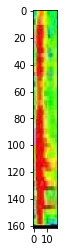

In [4]:
#vizualizacia po augmentacii
transformed_image = AUGMENTATIONS(image=img)["image"]
plt.imshow(transformed_image)

Dátová množina pochádza z anotačného projektu. Trénovacia zložka obsahuje 2322 eventov a testovacia 175 eventov. Dátovú množinu normalizujeme a inicializujeme ImageDataAugmentor. Pri trénovaní modelu sa na každej batchy generujú nové augmentované obrázky.

In [5]:
#nacitanie trenovacej a testovacej zlozky dat vytvorenej v Normal_net.ipynb
x = pickle.load(open('X_train_norm.pkl', 'rb'))
y = pickle.load(open('y_train_norm.pkl', 'rb'))

x_test = pickle.load(open('X_test.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))

In [6]:
#normalizacia
x = np.asarray(x, dtype=np.float32)/255
x_test = np.asarray(x_test, dtype=np.float32)/255

In [7]:
#datagen inicializacia
datagen = ImageDataAugmentor(
    seed = SEED,
    augment=AUGMENTATIONS,
    validation_split=0.2)

In [8]:
#nasadenie datagenu na trenovacich datach s ich rozdelenim na podzlozky
datagen.fit(x, augment=True)
train_generator = datagen.flow(x, y, batch_size=32, subset='training', shuffle = False)
validation_generator = datagen.flow(x, y, batch_size=32, subset='validation', shuffle = False)

# 3. Hlboké učenie
Hlboké učenie je realizované neurónovou sieťou. Ukladaný je najlepší model z hľadiska validačnej straty. Model je trénovaný na 30 epoch.

In [9]:
#neuronova siet
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(150,40,3)))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(4, activation = 'softmax'))

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [11]:
saved_model = "model_datagen_RBG.h5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint]

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator), 
    callbacks = callbacks_list
)

Epoch 1/30
57/59 [===========================>..] - ETA: 0s - loss: 1.3403 - accuracy: 0.3322
Epoch 00001: val_loss improved from inf to 1.31680, saving model to model_datagen_RBG.h5
59/59 [==============================] - 2s 32ms/step - loss: 1.3345 - accuracy: 0.3358 - val_loss: 1.3168 - val_accuracy: 0.4138
Epoch 2/30
58/59 [============================>.] - ETA: 0s - loss: 1.2249 - accuracy: 0.4277
Epoch 00002: val_loss improved from 1.31680 to 1.25269, saving model to model_datagen_RBG.h5
59/59 [==============================] - 1s 25ms/step - loss: 1.2240 - accuracy: 0.4290 - val_loss: 1.2527 - val_accuracy: 0.4095
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 1.0855 - accuracy: 0.5032
Epoch 00003: val_loss improved from 1.25269 to 0.96643, saving model to model_datagen_RBG.h5
59/59 [==============================] - 1s 25ms/step - loss: 1.0855 - accuracy: 0.5032 - val_loss: 0.9664 - val_accuracy: 0.5884
Epoch 4/30
59/59 [==============================] - E

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 38, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 19, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 9, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 7, 64)         36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 4, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 2, 64)         3

# 4. Vyhodnotenie modelu
Trénovacia a validačná strata

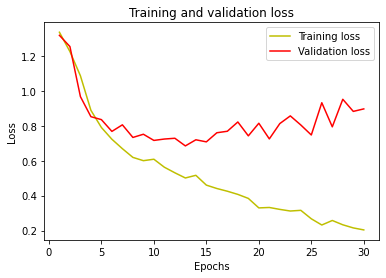

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Trénovacia a validačná presnosť

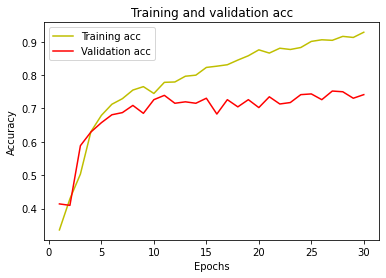

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Načítame najlepší model a použijeme ho na predikciu testovacej množiny. Predikciu modelu a True label spojíme do tabuľky a vytvoríme kontingenčnú tabuľku a klasifikačný report modelu.

In [16]:
#nacitanie najlepsieho modelu
a = load_model('model_datagen_RBG.h5')

In [17]:
#predikovanie na testovacej zlozke dat
predictions = a.predict_classes(x_test, batch_size = 30)
predictions

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2])

In [18]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [19]:
df = pd.DataFrame(list(zip(y_test, predictions)), columns =['True', 'Prediction'])
df

,True,Prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
170,3,2
171,3,3
172,3,3
173,3,3


In [20]:
y_true = df['True']
y_pred = df['Prediction']

In [21]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
classification_report = sklearn.metrics.classification_report(y_true, y_pred)
print(confusion_matrix)

[[44  1  1  0]
 [ 1 22  2  0]
 [ 1  3 57  1]
 [ 0  0  4 38]]


Presnosť modelu dosahuje na testovacej množine 92%. Najlepšie vie model predikovať triedy 0 a 3, najhoršie triedu 1.

In [22]:
#vyhodnotenie
print(classification_report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        46
           1       0.85      0.88      0.86        25
           2       0.89      0.92      0.90        62
           3       0.97      0.90      0.94        42

    accuracy                           0.92       175
   macro avg       0.92      0.92      0.92       175
weighted avg       0.92      0.92      0.92       175



# 5. Vizuálne overenie nesprávne zaklasifikovaných udalostí
Vytvoríme tabuľku obsahujúcu informácie o eventoch pozostávajúcu s Labelu, Predikcie, Predspracovaného obrázku a Mena obrázku. Ďalej vyfiltrujeme len nesprávne predikované eventy a zobrazíme ich pre vizuálnu kontrolu.

In [23]:
preds = df
preds.to_csv('predictions_datagen.csv', index=False)

In [24]:
X_test = pickle.load(open('X_test.pkl', 'rb'))
preds = pd.read_csv("predictions_datagen.csv")
images = pickle.load(open('images.pkl', 'rb'))

In [25]:
preds_true = preds['True']
preds_preds = preds['Prediction']
to_plot = pd.DataFrame(list(zip(preds_true, preds_preds, X_test, images)), columns =['True', 'Prediction', 'Img', 'F_name'])

false_pred = to_plot.drop(to_plot.index[to_plot['True'] == to_plot['Prediction']])
false_pred = false_pred.reset_index()
false_pred =false_pred.drop(columns=['index'])
false_pred['True'].replace({0:1, 1:2, 2:3, 3:4}, inplace = True)
false_pred['Prediction'].replace({0:1, 1:2, 2:3, 3:4}, inplace = True)

Z vizuálnej kontroly je vidieť, že množstvo eventov, ktoré boli nesprávne predikované je veľmi ťažké s určitosťou zaradiť do konkrétnej triedy. Predikcia modelu teda nemusí byť nutne zlá ak sa ani doménový expert nevie s určitosťou rozhodnúť o zaradení eventu do triedy.

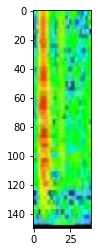

Image:  ['ch1_20160830_192500_741_s113_966.jpg']
Predikcia:  3
True:  1


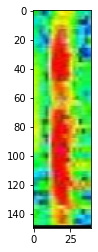

Image:  ['ch1_20150902_232433_673_s52_426.jpg']
Predikcia:  2
True:  1


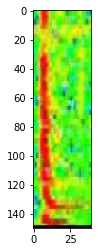

Image:  ['ch1_20180621_223609_070_s3_2239.jpg']
Predikcia:  1
True:  2


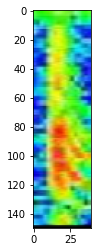

Image:  ['ch1_20150902_233434_128_s29_836.jpg']
Predikcia:  3
True:  2


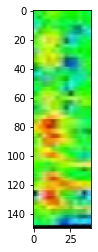

Image:  ['ch1_20160830_192500_741_s44_1091.jpg']
Predikcia:  3
True:  2


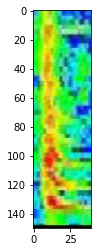

Image:  ['ch1_20180602_211730_150_s10_1831.jpg']
Predikcia:  4
True:  3


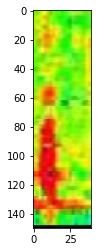

Image:  ['ch1_20150915_193335_458_s25_145.jpg']
Predikcia:  1
True:  3


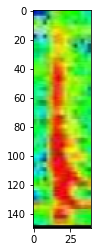

Image:  ['ch1_20180621_230110_099_s143_1568.jpg']
Predikcia:  2
True:  3


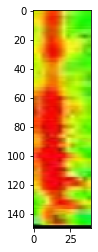

Image:  ['ch1_20180602_211229_947_s144_744.jpg']
Predikcia:  2
True:  3


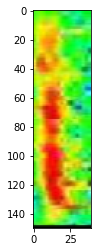

Image:  ['ch1_20180602_210229_548_s109_1115.jpg']
Predikcia:  2
True:  3


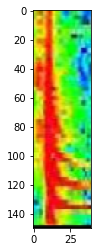

Image:  ['ch1_20180615_202506_686_s13_2735.jpg']
Predikcia:  3
True:  4


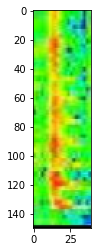

Image:  ['ch1_20160815_202845_581_s142_742.jpg']
Predikcia:  3
True:  4


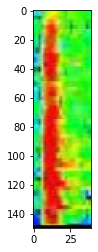

Image:  ['ch1_20150902_235935_260_s34_2809.jpg']
Predikcia:  3
True:  4


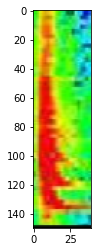

Image:  ['ch1_20160821_190510_640_s21_2433.jpg']
Predikcia:  3
True:  4


In [26]:
#vykreslenie nespravnych predikcii modelu
for ind in false_pred.index:
    plt.imshow(false_pred['Img'][ind])
    plt.show()
    print('Image: ', false_pred['F_name'][ind])
    print('Predikcia: ', false_pred['Prediction'][ind])
    print('True: ', false_pred['True'][ind])